In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from random import randint, choice, random
from typing import Union, Tuple, Callable

In [ ]:
def min_max_norm(val, min_val, max_val, new_min, new_max) -> float:
    return (val - min_val) * (new_max - new_min) / (max_val - min_val) + new_min

In [ ]:
def function(x1: float, x2: float) -> float:
    return 1.5 - np.exp(-x1**2 - x2**2) - 0.5*np.exp(-(x1-1)**2 -(x2+2)**2)

In [ ]:
class Chromosome:
    # if array is None it should be initialized with random binary vector
    def __init__(self, length: int, array: Union[list[int], None]=None) -> None:
        if array:
            self.array = array
        else:
            self.array = [randint(0, 1) for i in range(length)]
        self.length = length

    def decode(self, lower_bound: int, upper_bound: int, aoi: Tuple[float, float]) -> float:
        # Converts binary self.array to decimal value resized to fit aoi
        decimalValue = 0
        arrayExtracted = self.array[lower_bound:upper_bound]
        powerOfTwo = len(arrayExtracted) - 1
        for position in arrayExtracted:
            decimalValue += position * 2**powerOfTwo
            powerOfTwo -= 1

        maxValue = sum([2**i for i in range(len(arrayExtracted))])

        valueMinMaxed = min_max_norm(decimalValue, 0, maxValue, aoi[0], aoi[1])
        return valueMinMaxed

    def mutation(self, probability: float) -> bool:
        # Performs mutation of 1 cell in self.array based on probability
        ifChange: bool = random() < probability
        if ifChange:
            idToChange: int  = randint(0, self.length - 1)
            self.array[idToChange] = 1 - self.array[idToChange]
            return True
        return False

    def crossover(self, other: "Chromosome") -> Tuple["Chromosome", "Chromosome"]:
        # Splits this and other chromosome into 2 parts each
        # Two halves are swapped to create 2 new children
        pivot = randint(1, self.length - 2)
        leftPartA = self.array[:pivot]
        rightPartA = self.array[pivot:]

        leftPartB = other.array[:pivot]
        rightPartB = other.array[pivot:]

        childArrAB = leftPartA + rightPartB
        childArrBA = leftPartB + rightPartA

        childAB = Chromosome(self.length, childArrAB)
        childBA = Chromosome(self.length, childArrBA)

        return (childAB, childBA)

In [ ]:
class GeneticAlgorithm:
    def __init__(self, chromosome_length: int, obj_func_num_args: int, objective_function: Callable,
               aoi: Tuple[Tuple[float, float], Tuple[float, float]], population_size: int=1000, tournament_size: int=2,
               mutation_probability: float=0.05, crossover_probability: float=0.8, num_steps: int=30) -> None:
        assert chromosome_length % obj_func_num_args == 0, "Number of bits for each argument should be equal"
        self.chromosome_lengths = chromosome_length
        self.obj_func_num_args = obj_func_num_args
        self.bits_per_arg = int(chromosome_length / obj_func_num_args)
        self.objective_function = objective_function
        self.aoi = aoi
        self.population_size = population_size
        self.tournament_size = tournament_size
        self.mutation_probability = mutation_probability
        self.crossover_probability = crossover_probability
        self.num_steps = num_steps

    def eval_objective_func(self, chromosome: "Chromosome") -> float:
        # Evaluates function value for given chromosome
        midPoint = self.chromosome_lengths // 2
        chromosomeX1 = chromosome.decode(0, midPoint, self.aoi[0])
        chromosomeX2 = chromosome.decode(midPoint, self.chromosome_lengths, self.aoi[1])
        functionValue = self.objective_function(chromosomeX1, chromosomeX2)
        return functionValue

    def tournament_selection(self, population: list["Chromosome"]):
        for round in range(self.population_size * self.tournament_size):
            tournamenParticipants = []
            for participant in range(self.tournament_size):
                tournamenParticipants.append(choice(population))
            winner = min(tournamenParticipants, key=self.eval_objective_func)
            yield winner

    def reproduce(self, parents: Tuple["Chromosome", "Chromosome"]) -> Tuple["Chromosome", "Chromosome"]:
        ifReproduce: bool = random() < self.crossover_probability
        if ifReproduce:
            child1, child2 = parents[0].crossover(parents[1])
            child1.mutation(self.mutation_probability)
            child2.mutation(self.mutation_probability)
            return (child1, child2)
        else:
            return (parents[0], parents[1])

    def plot_func(self, trace, title):
      X = np.arange(-2, 3, 0.05)
      Y = np.arange(-4, 2, 0.05)
      X, Y = np.meshgrid(X, Y)
      Z = 1.5 - np.exp(-X ** (2) - Y ** (2)) - 0.5 * np.exp(-(X - 1) ** (2) - (Y + 2) ** (2))
      plt.figure()
      plt.contour(X, Y, Z, 10)
      cmaps = [[ii / len(trace), 0, 0] for ii in range(len(trace))]
      plt.scatter([x[0] for x in trace], [x[1] for x in trace], c=cmaps)
      plt.title(title)
      plt.show()

    def run(self, verbose:bool=False, plot:bool=False, plotTitle:str="") -> None:
        population = [Chromosome(self.chromosome_lengths) for _ in range(self.population_size)]
        trace: list[Tuple[float, float, float]] = []
        # trace is in form [(x1,x2,y), ...]

        for generation in range(self.num_steps):
            # start with finding, decodin and adding to trace best chromsome in generation
            population.sort(key=self.eval_objective_func)
            bestChromosome = population[0]
            bestChX1 = bestChromosome.decode(0 ,self.chromosome_lengths // 2, self.aoi[0])
            bestChX2 = bestChromosome.decode(self.chromosome_lengths // 2, self.chromosome_lengths, self.aoi[1])
            bestChY  = self.eval_objective_func(bestChromosome)
            trace.append((bestChX1, bestChX2, bestChY))

            # tournament selection
            selectedParents = list(self.tournament_selection(population))

            # due to varying tournament size parents amount may not be even
            if len(selectedParents) % 2 != 0:
                selectedParents.append(choice(population))

            newPopulation = []
            for i in range(0, len(selectedParents), 2):
                parent1, parent2 = selectedParents[i], selectedParents[i+1]
                child1, child2 = self.reproduce((parent1, parent2))
                newPopulation.extend([child1, child2])

            # replace population with new one, making sure to keep stable population size
            if len(newPopulation) == len(population):
                population = newPopulation
            else:
                population = newPopulation[:self.population_size]

        if verbose:
            gen = 1
            for element in trace:
                # precison when printing is
                #  4 decimal places
                print(f'Generation: {gen}, x1: {element[0]:.4f}, x2: {element[1]:.4f}, y: {element[2]:.4f}')
                gen += 1
            # print("last generation size: " + str(len(population)))
        # print("trace length: " + str(len(trace)))
        trace = np.array(trace)

        if plot:
            plot_title = f"{plotTitle}, last point: {trace[-1][0]:.4f}, {trace[-1][1]:.4f}, {trace[-1][2]:.4f}"
            self.plot_func(trace, plot_title)

In [ ]:
def testGA(chrom_len, popul_size, tourn_size, mut_prob, cross_prob, num_steps, title):
    aoi = ((-1.8, 2.1), (-3.1, 1.2))
    ga1 = GeneticAlgorithm(chrom_len, 2, function, aoi, popul_size, tourn_size, mut_prob, cross_prob, num_steps)
    ga1.run(verbose=True, plot=True, plotTitle=title)

Generation: 1, x1: 0.0147, x2: -0.2081, y: 0.5350
Generation: 2, x1: 0.0147, x2: -0.1787, y: 0.5248
Generation: 3, x1: 0.0147, x2: -0.1535, y: 0.5172
Generation: 4, x1: 0.0147, x2: -0.1661, y: 0.5209
Generation: 5, x1: 0.0452, x2: 0.0189, y: 0.4990
Generation: 6, x1: -0.0120, x2: 0.1113, y: 0.5104
Generation: 7, x1: 0.0185, x2: 0.0693, y: 0.5025
Generation: 8, x1: 0.0452, x2: -0.0190, y: 0.4984
Generation: 9, x1: -0.0158, x2: 0.0273, y: 0.4981
Generation: 10, x1: -0.0006, x2: 0.0357, y: 0.4984
Generation: 11, x1: 0.0147, x2: -0.0106, y: 0.4967
Generation: 12, x1: -0.0006, x2: 0.0273, y: 0.4977
Generation: 13, x1: -0.0196, x2: -0.0400, y: 0.4982
Generation: 14, x1: -0.0006, x2: -0.0064, y: 0.4966
Generation: 15, x1: -0.0006, x2: -0.0064, y: 0.4966
Generation: 16, x1: -0.0006, x2: -0.0064, y: 0.4966
Generation: 17, x1: -0.0006, x2: -0.0022, y: 0.4966
Generation: 18, x1: -0.0006, x2: -0.0106, y: 0.4966
Generation: 19, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 20, x1: 0.0032, x2: -0.0

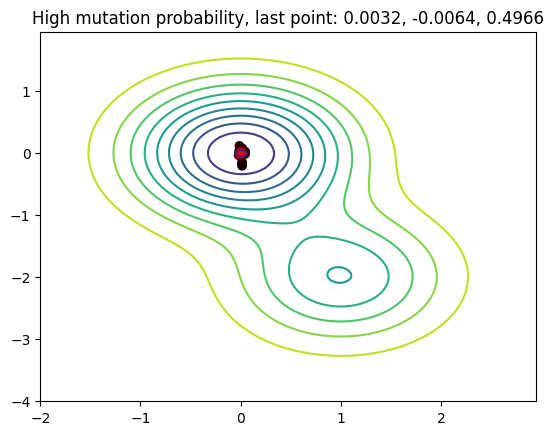

Generation: 1, x1: -0.0311, x2: -0.0988, y: 0.5060
Generation: 2, x1: -0.0311, x2: -0.0988, y: 0.5060
Generation: 3, x1: -0.0311, x2: -0.0988, y: 0.5060
Generation: 4, x1: -0.0311, x2: -0.0442, y: 0.4991
Generation: 5, x1: -0.0311, x2: -0.0232, y: 0.4980
Generation: 6, x1: -0.0235, x2: -0.0232, y: 0.4976
Generation: 7, x1: -0.0120, x2: -0.0232, y: 0.4971
Generation: 8, x1: -0.0120, x2: -0.0232, y: 0.4971
Generation: 9, x1: -0.0120, x2: -0.0106, y: 0.4968
Generation: 10, x1: -0.0120, x2: -0.0106, y: 0.4968
Generation: 11, x1: 0.0185, x2: -0.0106, y: 0.4968
Generation: 12, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 13, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 14, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 15, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 16, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 17, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 18, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 19, x1: 0.0032, x2: -0.0106, y: 0.4966
Generation: 20, x1: 0.0032, x2

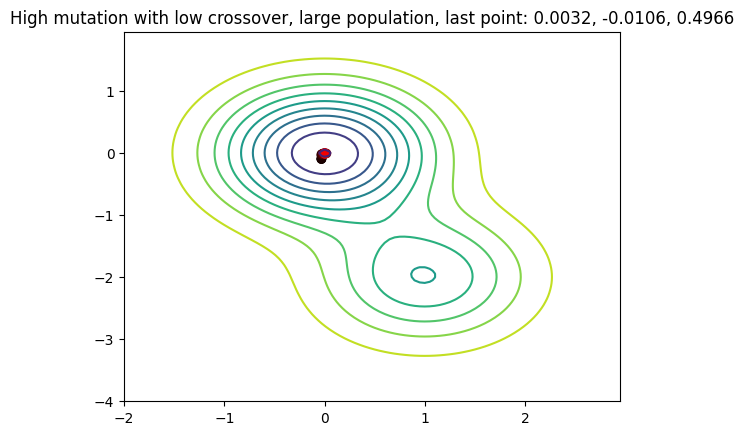

Generation: 1, x1: 0.4143, x2: 0.7359, y: 1.0097
Generation: 2, x1: -0.1790, x2: 0.2528, y: 0.5907
Generation: 3, x1: -0.1790, x2: 0.2528, y: 0.5907
Generation: 4, x1: -0.1790, x2: 0.2528, y: 0.5907
Generation: 5, x1: -0.1790, x2: 0.2528, y: 0.5907
Generation: 6, x1: -0.1790, x2: 0.0050, y: 0.5293
Generation: 7, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 8, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 9, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 10, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 11, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 12, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 13, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 14, x1: -0.1790, x2: 0.0176, y: 0.5297
Generation: 15, x1: -0.1790, x2: 0.0176, y: 0.5297


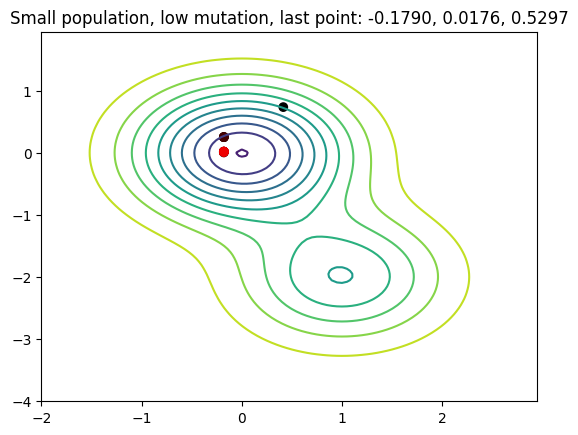

Generation: 1, x1: 0.1295, x2: 0.3726, y: 0.6432
Generation: 2, x1: 0.1581, x2: 0.2014, y: 0.5615
Generation: 3, x1: 0.1581, x2: 0.1489, y: 0.5436
Generation: 4, x1: 0.0533, x2: -0.0874, y: 0.5052
Generation: 5, x1: 0.0533, x2: -0.0874, y: 0.5052
Generation: 6, x1: 0.0533, x2: -0.0874, y: 0.5052
Generation: 7, x1: 0.0533, x2: -0.0874, y: 0.5052
Generation: 8, x1: 0.0362, x2: -0.0874, y: 0.5038
Generation: 9, x1: 0.0514, x2: -0.0191, y: 0.4990
Generation: 10, x1: 0.0514, x2: -0.0191, y: 0.4990


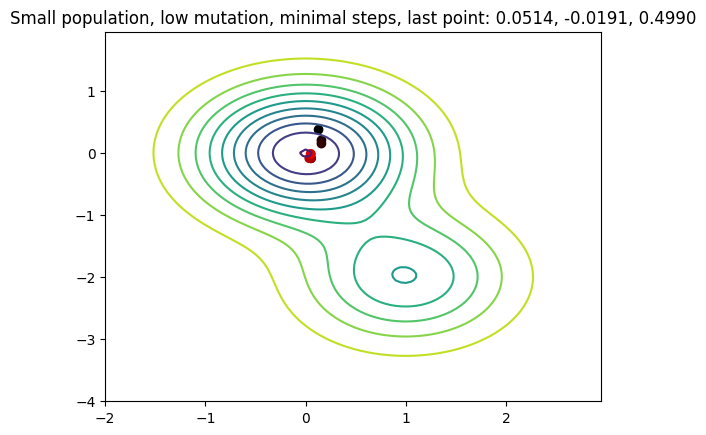

Generation: 1, x1: 0.0216, x2: 0.0583, y: 0.5011
Generation: 2, x1: -0.0020, x2: 0.0094, y: 0.4969
Generation: 3, x1: -0.0020, x2: 0.0087, y: 0.4968
Generation: 4, x1: 0.0023, x2: 0.0094, y: 0.4968
Generation: 5, x1: -0.0020, x2: 0.0052, y: 0.4967
Generation: 6, x1: 0.0004, x2: -0.0039, y: 0.4966
Generation: 7, x1: 0.0023, x2: -0.0039, y: 0.4966
Generation: 8, x1: 0.0023, x2: -0.0073, y: 0.4966
Generation: 9, x1: 0.0037, x2: -0.0073, y: 0.4966
Generation: 10, x1: 0.0037, x2: -0.0073, y: 0.4966
Generation: 11, x1: 0.0037, x2: -0.0073, y: 0.4966
Generation: 12, x1: 0.0037, x2: -0.0073, y: 0.4966
Generation: 13, x1: 0.0035, x2: -0.0073, y: 0.4966
Generation: 14, x1: 0.0035, x2: -0.0073, y: 0.4966
Generation: 15, x1: 0.0035, x2: -0.0073, y: 0.4966
Generation: 16, x1: 0.0035, x2: -0.0073, y: 0.4966
Generation: 17, x1: 0.0035, x2: -0.0073, y: 0.4966
Generation: 18, x1: 0.0035, x2: -0.0073, y: 0.4966
Generation: 19, x1: 0.0035, x2: -0.0073, y: 0.4966
Generation: 20, x1: 0.0035, x2: -0.0073, y

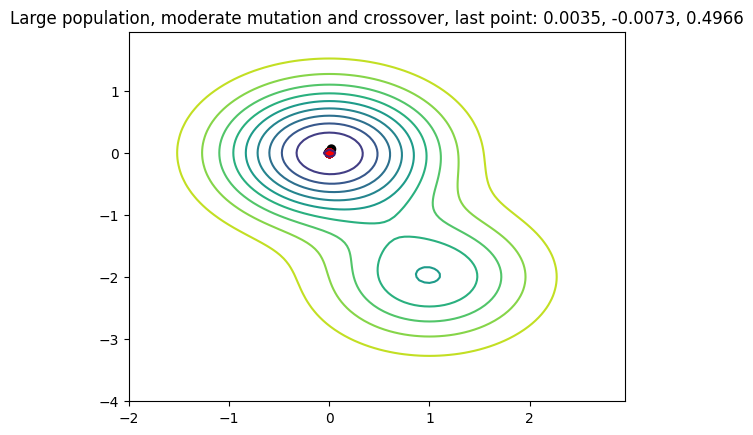

Generation: 1, x1: -0.0213, x2: -0.0291, y: 0.4977
Generation: 2, x1: 0.0316, x2: -0.0375, y: 0.4982
Generation: 3, x1: -0.0137, x2: 0.0192, y: 0.4975
Generation: 4, x1: -0.0137, x2: 0.0102, y: 0.4971
Generation: 5, x1: 0.0111, x2: -0.0013, y: 0.4967
Generation: 6, x1: -0.0022, x2: 0.0108, y: 0.4969
Generation: 7, x1: -0.0039, x2: 0.0029, y: 0.4967
Generation: 8, x1: -0.0006, x2: -0.0071, y: 0.4966
Generation: 9, x1: 0.0016, x2: -0.0047, y: 0.4966
Generation: 10, x1: 0.0009, x2: -0.0039, y: 0.4966
Generation: 11, x1: 0.0009, x2: -0.0039, y: 0.4966
Generation: 12, x1: -0.0006, x2: -0.0071, y: 0.4966
Generation: 13, x1: 0.0013, x2: -0.0071, y: 0.4966
Generation: 14, x1: 0.0037, x2: -0.0071, y: 0.4966
Generation: 15, x1: 0.0037, x2: -0.0071, y: 0.4966
Generation: 16, x1: 0.0032, x2: -0.0071, y: 0.4966
Generation: 17, x1: 0.0032, x2: -0.0068, y: 0.4966
Generation: 18, x1: 0.0037, x2: -0.0071, y: 0.4966
Generation: 19, x1: 0.0035, x2: -0.0071, y: 0.4966
Generation: 20, x1: 0.0035, x2: -0.00

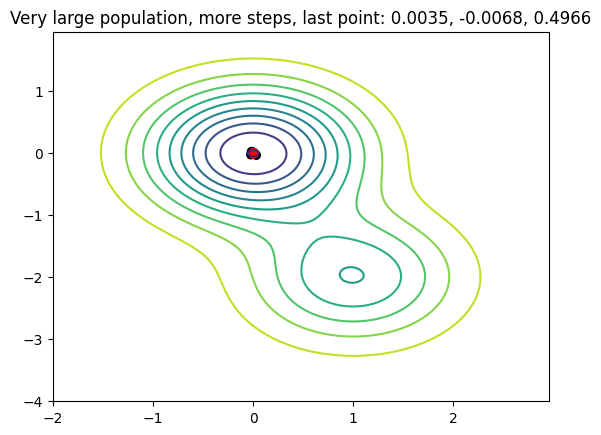

Generation: 1, x1: -0.0705, x2: -0.0518, y: 0.5041
Generation: 2, x1: -0.0705, x2: -0.0707, y: 0.5061
Generation: 3, x1: -0.0705, x2: -0.0686, y: 0.5058
Generation: 4, x1: -0.0514, x2: -0.0707, y: 0.5036
Generation: 5, x1: -0.0514, x2: -0.0160, y: 0.4997
Generation: 6, x1: -0.0097, x2: -0.0299, y: 0.4973
Generation: 7, x1: -0.0097, x2: -0.0299, y: 0.4973
Generation: 8, x1: -0.0097, x2: -0.0035, y: 0.4968
Generation: 9, x1: 0.0094, x2: -0.0035, y: 0.4966
Generation: 10, x1: 0.0094, x2: -0.0076, y: 0.4966
Generation: 11, x1: 0.0094, x2: -0.0076, y: 0.4966
Generation: 12, x1: 0.0057, x2: -0.0094, y: 0.4966
Generation: 13, x1: 0.0056, x2: -0.0076, y: 0.4966
Generation: 14, x1: 0.0056, x2: -0.0076, y: 0.4966
Generation: 15, x1: 0.0018, x2: -0.0073, y: 0.4966
Generation: 16, x1: 0.0018, x2: -0.0073, y: 0.4966
Generation: 17, x1: 0.0018, x2: -0.0073, y: 0.4966
Generation: 18, x1: 0.0018, x2: -0.0073, y: 0.4966
Generation: 19, x1: 0.0018, x2: -0.0073, y: 0.4966
Generation: 20, x1: 0.0018, x2: 

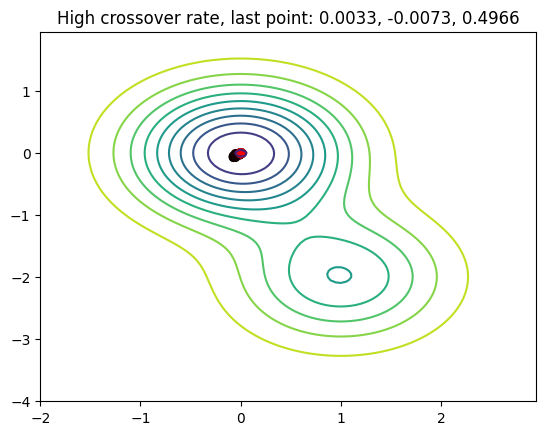

Generation: 1, x1: 0.0149, x2: 0.0128, y: 0.4971
Generation: 2, x1: 0.0149, x2: 0.0128, y: 0.4971
Generation: 3, x1: 0.0149, x2: -0.0052, y: 0.4967
Generation: 4, x1: 0.0149, x2: -0.0064, y: 0.4967
Generation: 5, x1: 0.0100, x2: -0.0070, y: 0.4966
Generation: 6, x1: 0.0100, x2: -0.0067, y: 0.4966
Generation: 7, x1: 0.0072, x2: -0.0065, y: 0.4966
Generation: 8, x1: 0.0024, x2: -0.0052, y: 0.4966
Generation: 9, x1: 0.0024, x2: -0.0082, y: 0.4966
Generation: 10, x1: 0.0024, x2: -0.0065, y: 0.4966
Generation: 11, x1: 0.0024, x2: -0.0070, y: 0.4966
Generation: 12, x1: 0.0034, x2: -0.0063, y: 0.4966
Generation: 13, x1: 0.0034, x2: -0.0070, y: 0.4966
Generation: 14, x1: 0.0034, x2: -0.0070, y: 0.4966
Generation: 15, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 16, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 17, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 18, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 19, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 20, x1: 0.0034, x2: -0.0069, y

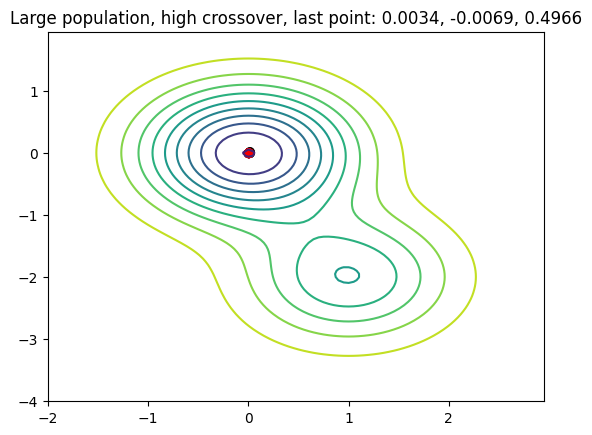

Generation: 1, x1: -0.1406, x2: -0.0982, y: 0.5253
Generation: 2, x1: -0.1406, x2: -0.0982, y: 0.5253
Generation: 3, x1: -0.1406, x2: -0.0982, y: 0.5253
Generation: 4, x1: -0.1406, x2: -0.0982, y: 0.5253
Generation: 5, x1: -0.0128, x2: -0.0982, y: 0.5049
Generation: 6, x1: -0.0128, x2: -0.0982, y: 0.5049
Generation: 7, x1: -0.0128, x2: -0.0982, y: 0.5049
Generation: 8, x1: -0.0128, x2: -0.0982, y: 0.5049
Generation: 9, x1: -0.0128, x2: -0.0982, y: 0.5049
Generation: 10, x1: -0.0035, x2: -0.0949, y: 0.5041
Generation: 11, x1: -0.0035, x2: -0.0949, y: 0.5041
Generation: 12, x1: -0.0035, x2: -0.0949, y: 0.5041
Generation: 13, x1: -0.0035, x2: -0.0949, y: 0.5041
Generation: 14, x1: -0.0035, x2: -0.0949, y: 0.5041
Generation: 15, x1: -0.0035, x2: -0.0949, y: 0.5041
Generation: 16, x1: -0.0033, x2: -0.0949, y: 0.5041
Generation: 17, x1: -0.0033, x2: -0.0949, y: 0.5041
Generation: 18, x1: -0.0033, x2: -0.0949, y: 0.5041
Generation: 19, x1: -0.0033, x2: -0.0949, y: 0.5041
Generation: 20, x1: -

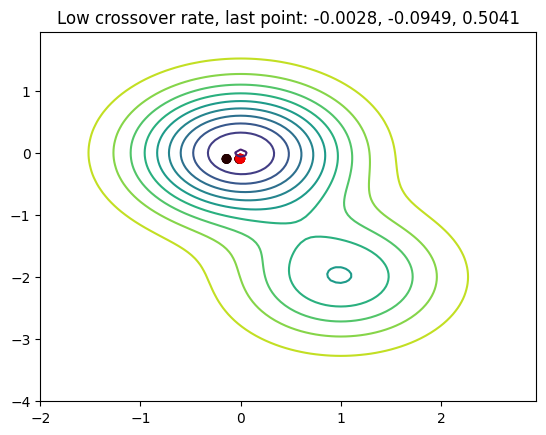

Generation: 1, x1: -0.1304, x2: -0.0159, y: 0.5144
Generation: 2, x1: 0.1028, x2: 0.1277, y: 0.5241
Generation: 3, x1: -0.1533, x2: 0.0184, y: 0.5213
Generation: 4, x1: 0.1349, x2: 0.0382, y: 0.5157
Generation: 5, x1: -0.0333, x2: 0.0167, y: 0.4984
Generation: 6, x1: -0.0327, x2: 0.0043, y: 0.4980
Generation: 7, x1: -0.0327, x2: 0.0043, y: 0.4980
Generation: 8, x1: -0.0327, x2: 0.0043, y: 0.4980
Generation: 9, x1: -0.0328, x2: -0.0144, y: 0.4979
Generation: 10, x1: -0.0328, x2: -0.0144, y: 0.4979
Generation: 11, x1: -0.0327, x2: -0.0067, y: 0.4979
Generation: 12, x1: -0.0327, x2: -0.0067, y: 0.4979
Generation: 13, x1: -0.0327, x2: -0.0067, y: 0.4979
Generation: 14, x1: -0.0257, x2: 0.0043, y: 0.4975
Generation: 15, x1: 0.0276, x2: 0.0042, y: 0.4973
Generation: 16, x1: -0.0024, x2: -0.0144, y: 0.4967
Generation: 17, x1: -0.0024, x2: -0.0144, y: 0.4967
Generation: 18, x1: -0.0024, x2: -0.0144, y: 0.4967
Generation: 19, x1: -0.0024, x2: -0.0144, y: 0.4967
Generation: 20, x1: -0.0024, x2: 

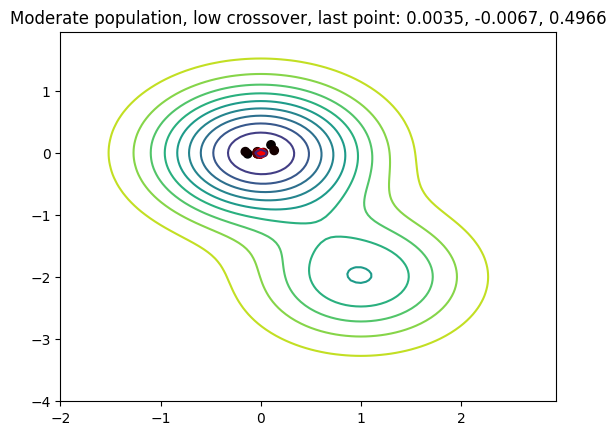

Generation: 1, x1: -0.0293, x2: -0.0464, y: 0.4992
Generation: 2, x1: -0.0293, x2: -0.0335, y: 0.4984
Generation: 3, x1: -0.0293, x2: -0.0272, y: 0.4981
Generation: 4, x1: -0.0293, x2: -0.0128, y: 0.4977
Generation: 5, x1: -0.0149, x2: -0.0128, y: 0.4969
Generation: 6, x1: 0.0011, x2: -0.0128, y: 0.4966
Generation: 7, x1: 0.0011, x2: -0.0104, y: 0.4966
Generation: 8, x1: 0.0011, x2: -0.0104, y: 0.4966
Generation: 9, x1: 0.0039, x2: -0.0104, y: 0.4966
Generation: 10, x1: 0.0011, x2: -0.0094, y: 0.4966
Generation: 11, x1: 0.0040, x2: -0.0094, y: 0.4966
Generation: 12, x1: 0.0039, x2: -0.0094, y: 0.4966
Generation: 13, x1: 0.0039, x2: -0.0094, y: 0.4966
Generation: 14, x1: 0.0034, x2: -0.0094, y: 0.4966
Generation: 15, x1: 0.0034, x2: -0.0094, y: 0.4966
Generation: 16, x1: 0.0034, x2: -0.0094, y: 0.4966
Generation: 17, x1: 0.0036, x2: -0.0094, y: 0.4966
Generation: 18, x1: 0.0036, x2: -0.0094, y: 0.4966
Generation: 19, x1: 0.0035, x2: -0.0094, y: 0.4966
Generation: 20, x1: 0.0035, x2: -0.

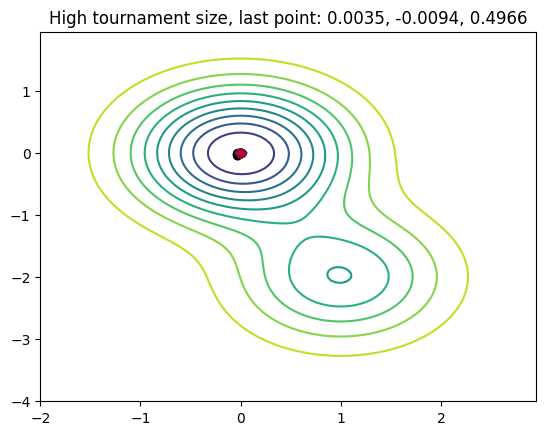

Generation: 1, x1: -0.0118, x2: -0.0797, y: 0.5020
Generation: 2, x1: 0.0323, x2: -0.0147, y: 0.4975
Generation: 3, x1: 0.0177, x2: 0.0021, y: 0.4969
Generation: 4, x1: -0.0031, x2: -0.0147, y: 0.4967
Generation: 5, x1: 0.0041, x2: -0.0105, y: 0.4966
Generation: 6, x1: 0.0041, x2: -0.0104, y: 0.4966
Generation: 7, x1: 0.0034, x2: -0.0068, y: 0.4966
Generation: 8, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 9, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 10, x1: 0.0034, x2: -0.0069, y: 0.4966
Generation: 11, x1: 0.0035, x2: -0.0069, y: 0.4966
Generation: 12, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 13, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 14, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 15, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 16, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 17, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 18, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 19, x1: 0.0035, x2: -0.0070, y: 0.4966
Generation: 20, x1: 0.0035, x2: -0.0070

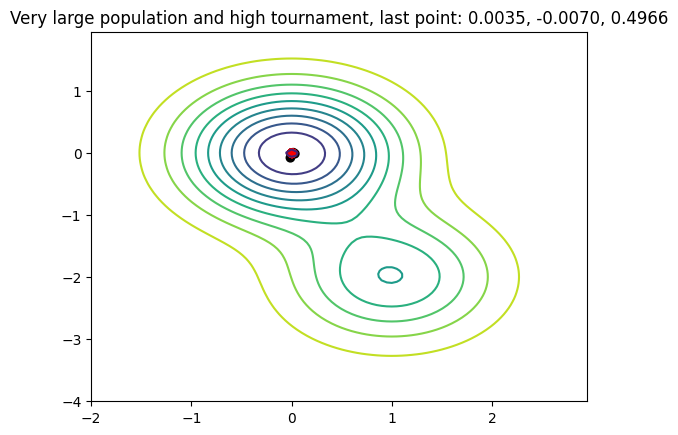

Generation: 1, x1: 0.0009, x2: 0.2102, y: 0.5418
Generation: 2, x1: 0.0009, x2: 0.2102, y: 0.5418
Generation: 3, x1: 0.0009, x2: 0.2102, y: 0.5418
Generation: 4, x1: 0.0008, x2: -0.1176, y: 0.5084
Generation: 5, x1: 0.0008, x2: -0.1176, y: 0.5084
Generation: 6, x1: 0.0008, x2: -0.1176, y: 0.5084
Generation: 7, x1: 0.0008, x2: -0.1175, y: 0.5084
Generation: 8, x1: 0.0009, x2: -0.0586, y: 0.4992
Generation: 9, x1: 0.0009, x2: -0.0586, y: 0.4992
Generation: 10, x1: 0.0009, x2: -0.0586, y: 0.4992
Generation: 11, x1: 0.0009, x2: -0.0586, y: 0.4992
Generation: 12, x1: 0.0009, x2: -0.0583, y: 0.4991
Generation: 13, x1: 0.0009, x2: -0.0583, y: 0.4991
Generation: 14, x1: 0.0009, x2: -0.0504, y: 0.4984
Generation: 15, x1: 0.0009, x2: -0.0504, y: 0.4984
Generation: 16, x1: 0.0009, x2: -0.0504, y: 0.4984
Generation: 17, x1: 0.0009, x2: -0.0504, y: 0.4984
Generation: 18, x1: 0.0009, x2: -0.0504, y: 0.4984
Generation: 19, x1: 0.0009, x2: -0.0499, y: 0.4984
Generation: 20, x1: 0.0009, x2: -0.0499, y:

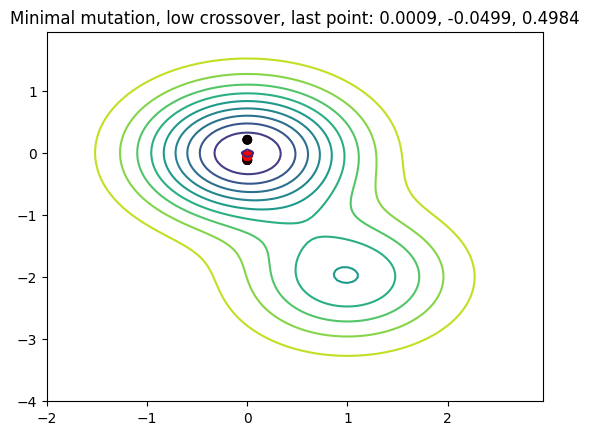

Generation: 1, x1: 0.0927, x2: 0.1175, y: 0.5197
Generation: 2, x1: 0.1002, x2: -0.0937, y: 0.5128
Generation: 3, x1: 0.1002, x2: -0.0937, y: 0.5128
Generation: 4, x1: 0.1002, x2: 0.0515, y: 0.5093
Generation: 5, x1: 0.0361, x2: 0.0559, y: 0.5015
Generation: 6, x1: 0.0361, x2: 0.0559, y: 0.5015
Generation: 7, x1: 0.0361, x2: 0.0559, y: 0.5015
Generation: 8, x1: 0.0036, x2: 0.0515, y: 0.4999
Generation: 9, x1: 0.0036, x2: 0.0515, y: 0.4999
Generation: 10, x1: 0.0036, x2: 0.0515, y: 0.4999
Generation: 11, x1: -0.0497, x2: 0.0059, y: 0.4995
Generation: 12, x1: -0.0497, x2: 0.0060, y: 0.4995
Generation: 13, x1: -0.0497, x2: 0.0060, y: 0.4995
Generation: 14, x1: -0.0497, x2: 0.0060, y: 0.4995
Generation: 15, x1: 0.0036, x2: 0.0395, y: 0.4987
Generation: 16, x1: 0.0036, x2: 0.0395, y: 0.4987
Generation: 17, x1: 0.0361, x2: 0.0060, y: 0.4978
Generation: 18, x1: 0.0036, x2: 0.0060, y: 0.4967
Generation: 19, x1: 0.0036, x2: 0.0060, y: 0.4967
Generation: 20, x1: 0.0036, x2: 0.0059, y: 0.4967
Gen

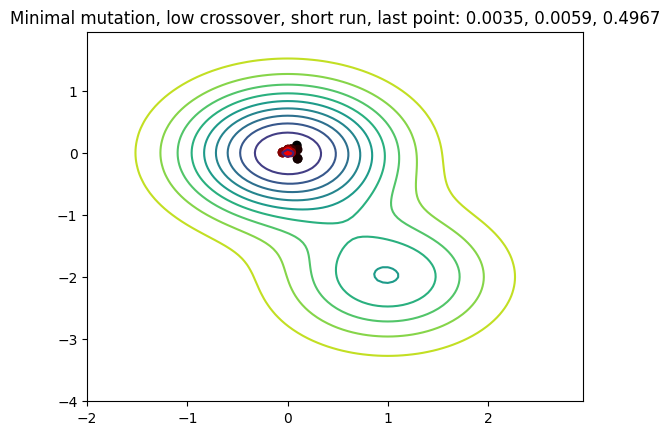

Generation: 1, x1: 0.0014, x2: -0.2207, y: 0.5398
Generation: 2, x1: 0.0014, x2: -0.2207, y: 0.5398
Generation: 3, x1: 0.0589, x2: 0.0672, y: 0.5051
Generation: 4, x1: 0.0589, x2: 0.0672, y: 0.5051
Generation: 5, x1: -0.0187, x2: -0.0750, y: 0.5016
Generation: 6, x1: -0.0187, x2: -0.0750, y: 0.5016
Generation: 7, x1: -0.0187, x2: -0.0750, y: 0.5016
Generation: 8, x1: 0.0191, x2: 0.0669, y: 0.5022
Generation: 9, x1: 0.0014, x2: 0.0672, y: 0.5019
Generation: 10, x1: 0.0191, x2: 0.0604, y: 0.5013
Generation: 11, x1: 0.0191, x2: 0.0604, y: 0.5013
Generation: 12, x1: 0.0014, x2: 0.0604, y: 0.5010
Generation: 13, x1: 0.0014, x2: 0.0604, y: 0.5010
Generation: 14, x1: 0.0003, x2: 0.0585, y: 0.5008
Generation: 15, x1: 0.0039, x2: 0.0604, y: 0.5010
Generation: 16, x1: 0.0039, x2: 0.0585, y: 0.5008
Generation: 17, x1: 0.0039, x2: 0.0585, y: 0.5008
Generation: 18, x1: 0.0039, x2: 0.0585, y: 0.5008
Generation: 19, x1: 0.0039, x2: 0.0585, y: 0.5008
Generation: 20, x1: 0.0039, x2: 0.0585, y: 0.5008
G

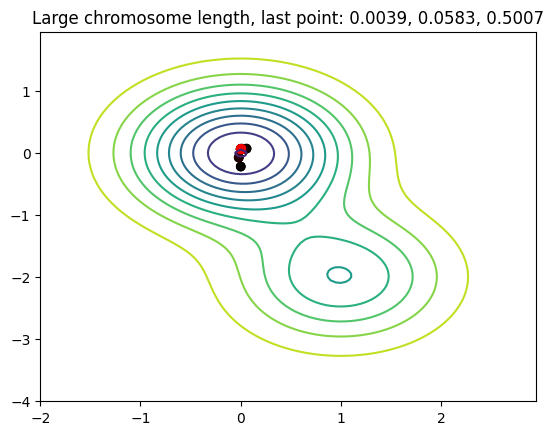

Generation: 1, x1: -0.0331, x2: 0.0067, y: 0.4981
Generation: 2, x1: -0.0331, x2: 0.0067, y: 0.4981
Generation: 3, x1: -0.0331, x2: 0.0057, y: 0.4980
Generation: 4, x1: -0.0020, x2: 0.0036, y: 0.4967
Generation: 5, x1: -0.0020, x2: 0.0036, y: 0.4967
Generation: 6, x1: -0.0020, x2: 0.0050, y: 0.4967
Generation: 7, x1: -0.0020, x2: 0.0050, y: 0.4967
Generation: 8, x1: -0.0012, x2: 0.0047, y: 0.4967
Generation: 9, x1: -0.0012, x2: -0.0064, y: 0.4966
Generation: 10, x1: 0.0012, x2: 0.0033, y: 0.4967
Generation: 11, x1: -0.0012, x2: -0.0048, y: 0.4966
Generation: 12, x1: -0.0012, x2: -0.0064, y: 0.4966
Generation: 13, x1: 0.0012, x2: -0.0048, y: 0.4966
Generation: 14, x1: 0.0029, x2: -0.0064, y: 0.4966
Generation: 15, x1: 0.0029, x2: -0.0064, y: 0.4966
Generation: 16, x1: 0.0033, x2: -0.0064, y: 0.4966
Generation: 17, x1: 0.0033, x2: -0.0064, y: 0.4966
Generation: 18, x1: 0.0033, x2: -0.0064, y: 0.4966
Generation: 19, x1: 0.0033, x2: -0.0064, y: 0.4966
Generation: 20, x1: 0.0033, x2: -0.007

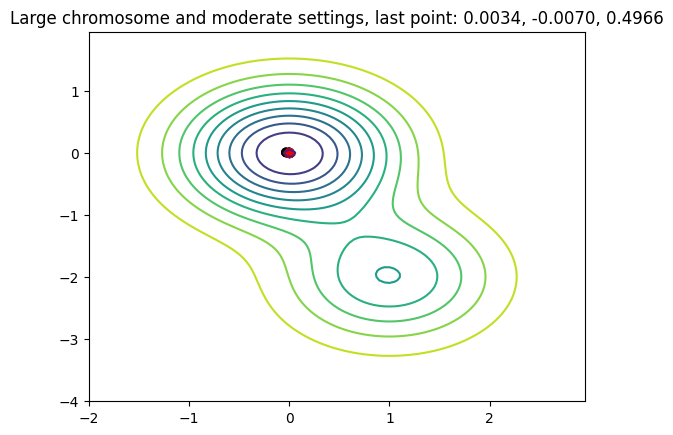

Generation: 1, x1: 0.0452, x2: -0.0610, y: 0.5011
Generation: 2, x1: 0.0452, x2: -0.0610, y: 0.5011
Generation: 3, x1: 0.0452, x2: -0.0610, y: 0.5011
Generation: 4, x1: 0.0452, x2: -0.0526, y: 0.5003
Generation: 5, x1: 0.0452, x2: -0.0526, y: 0.5003


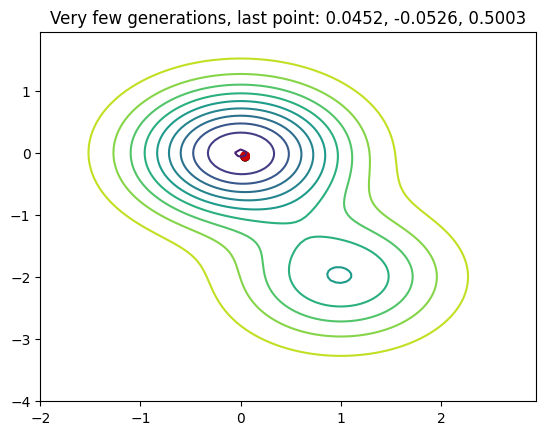

Generation: 1, x1: -0.0463, x2: 0.1870, y: 0.5350
Generation: 2, x1: -0.0463, x2: 0.1870, y: 0.5350
Generation: 3, x1: -0.0273, x2: 0.0273, y: 0.4986
Generation: 4, x1: 0.0185, x2: 0.0063, y: 0.4970
Generation: 5, x1: 0.0185, x2: 0.0063, y: 0.4970
Generation: 6, x1: -0.0044, x2: 0.0063, y: 0.4968
Generation: 7, x1: 0.0032, x2: -0.0022, y: 0.4966
Generation: 8, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 9, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 10, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 11, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 12, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 13, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 14, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 15, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 16, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 17, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 18, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 19, x1: 0.0032, x2: -0.0064, y: 0.4966
Generation: 20, x1: 0.0032, x2: -0.0064, y

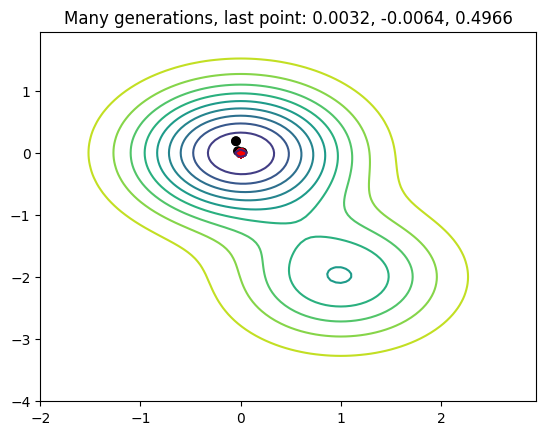

Generation: 1, x1: 0.0639, x2: -0.0457, y: 0.5016
Generation: 2, x1: 0.0639, x2: -0.0457, y: 0.5016
Generation: 3, x1: 0.0334, x2: -0.0443, y: 0.4988
Generation: 4, x1: -0.0140, x2: -0.0115, y: 0.4969
Generation: 5, x1: -0.0140, x2: -0.0115, y: 0.4969
Generation: 6, x1: 0.0012, x2: -0.0115, y: 0.4966
Generation: 7, x1: 0.0029, x2: -0.0107, y: 0.4966
Generation: 8, x1: 0.0029, x2: -0.0107, y: 0.4966
Generation: 9, x1: 0.0029, x2: -0.0107, y: 0.4966
Generation: 10, x1: 0.0012, x2: -0.0094, y: 0.4966
Generation: 11, x1: 0.0030, x2: -0.0094, y: 0.4966
Generation: 12, x1: 0.0031, x2: -0.0094, y: 0.4966
Generation: 13, x1: 0.0031, x2: -0.0094, y: 0.4966
Generation: 14, x1: 0.0031, x2: -0.0094, y: 0.4966
Generation: 15, x1: 0.0031, x2: -0.0094, y: 0.4966
Generation: 16, x1: 0.0033, x2: -0.0094, y: 0.4966
Generation: 17, x1: 0.0033, x2: -0.0094, y: 0.4966
Generation: 18, x1: 0.0033, x2: -0.0094, y: 0.4966
Generation: 19, x1: 0.0034, x2: -0.0094, y: 0.4966
Generation: 20, x1: 0.0034, x2: -0.009

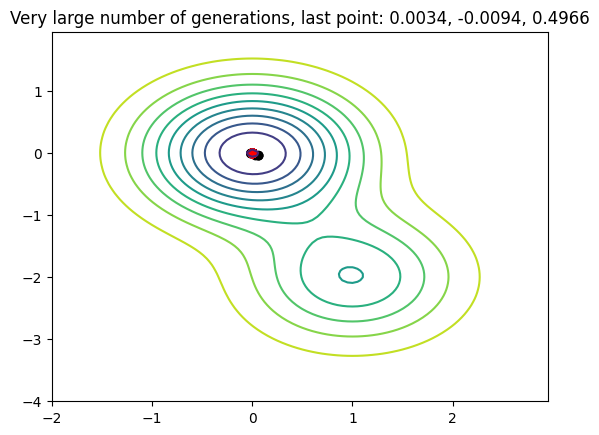

Generation: 1, x1: -0.0457, x2: -0.0480, y: 0.5007
Generation: 2, x1: 0.0252, x2: 0.0302, y: 0.4984
Generation: 3, x1: -0.0067, x2: 0.0414, y: 0.4989
Generation: 4, x1: 0.0151, x2: -0.0037, y: 0.4967
Generation: 5, x1: 0.0099, x2: -0.0019, y: 0.4966
Generation: 6, x1: 0.0098, x2: -0.0034, y: 0.4966
Generation: 7, x1: 0.0166, x2: -0.0174, y: 0.4968
Generation: 8, x1: -0.0024, x2: 0.0006, y: 0.4967
Generation: 9, x1: 0.0155, x2: -0.0123, y: 0.4967
Generation: 10, x1: 0.0034, x2: 0.0006, y: 0.4966
Generation: 11, x1: 0.0023, x2: -0.0038, y: 0.4966
Generation: 12, x1: 0.0023, x2: -0.0068, y: 0.4966
Generation: 13, x1: -0.0023, x2: -0.0081, y: 0.4966
Generation: 14, x1: 0.0078, x2: -0.0090, y: 0.4966
Generation: 15, x1: 0.0023, x2: -0.0078, y: 0.4966
Generation: 16, x1: 0.0039, x2: -0.0080, y: 0.4966
Generation: 17, x1: 0.0039, x2: -0.0080, y: 0.4966
Generation: 18, x1: 0.0039, x2: -0.0078, y: 0.4966
Generation: 19, x1: 0.0042, x2: -0.0074, y: 0.4966
Generation: 20, x1: 0.0034, x2: -0.0078,

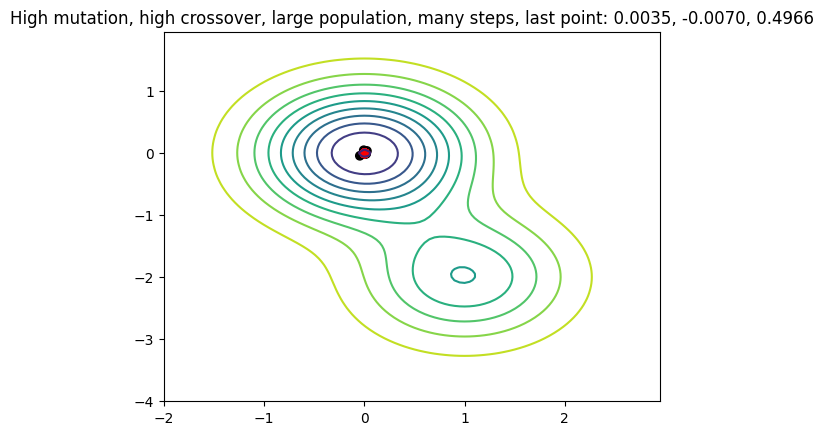

In [ ]:
def main():
    # Test cases with varied and extreme parameters, each with a descriptive title
    array = [(1,1,1), (2,2,2), (-1,-1,-1), (-2,-2,-2)]


    test_cases = [
    # chr_l,pop_s, t_s,mut_p,cros_p,num_s,  title
        (20, 100,  2,  0.5,   0.9,  30,  "High mutation probability"),                          #1
        (20, 1000, 3,  0.5,   0.1,  20,  "High mutation with low crossover, large population"), #2
        (24, 10,   2,  0.01,  0.8,  15,  "Small population, low mutation"),                     #3
        (24, 50,   3,  0.02,  0.6,  10,  "Small population, low mutation, minimal steps"),      #4
        (28, 1000, 5,  0.03,  0.85, 50,  "Large population, moderate mutation and crossover"),  #5
        (28, 2000, 2,  0.02,  0.75, 100, "Very large population, more steps"),                  #6
        (30, 100,  3,  0.05,  0.99, 40,  "High crossover rate"),                                #7
        (30, 500,  4,  0.05,  0.95, 30,  "Large population, high crossover"),                   #8
        (32, 200,  3,  0.03,  0.1,  20,  "Low crossover rate"),                                 #9
        (32, 500,  2,  0.04,  0.2,  35,  "Moderate population, low crossover"),                 #10
        (36, 300,  10, 0.06,  0.8,  45,  "High tournament size"),                               #11
        (36, 1000, 8,  0.04,  0.9,  50,  "Very large population and high tournament"),          #12
        (40, 100,  2,  0.001, 0.2,  60,  "Minimal mutation, low crossover"),                    #13
        (40, 200,  2,  0.001, 0.3,  25,  "Minimal mutation, low crossover, short run"),         #14
        (64, 100,  2,  0.01,  0.75, 50,  "Large chromosome length"),                            #15
        (64, 300,  3,  0.05,  0.85, 30,  "Large chromosome and moderate settings"),             #16
        (20, 200,  3,  0.03,  0.7,  5,   "Very few generations"),                               #17
        (20, 200,  3,  0.03,  0.7,  100, "Many generations"),                                   #17
        (40, 300,  5,  0.02,  0.8,  200, "Very large number of generations"),                   #18
        (40, 2000, 2,  0.5,   0.9,  150, "High mutation, high crossover, large population, many steps"), #19
    ]

    for idx, (chrom_len, popul_size, tourn_size, mut_prob, cross_prob, num_steps, title) in enumerate(test_cases, start=1):
        testGA(chrom_len, popul_size, tourn_size, mut_prob, cross_prob, num_steps, title)

if __name__ == "__main__":
    main()

Duża populacja zapewnia w miarę równe rozmieszczenie puntków w pierwszym pokoleniu, co sprawia, że prawdopodobieństwo mutacji, krzyżowania i ilość pokoleń wcale nie muszą być duże, aby w miare szybko znaleźć się blisko optimum.

W dużej popluacji krzyżowanie może skuteczniej zbadać przestrzeń poszukiwań, gdyż punkty są zazwyczaj równomiernie rozmieszczone, tj. wprowadza większą różnorodność chromosomów.

W przypadku małej populacji często samo krzyżowanie często jest niewystarczające i populacja musi polegać na mutacjach, które mogą ją "popchnąć" w kierunku optimum. Często do tego potrzebne jest dużo pokoleń.

W małej populacji jest większe ryzyko tego, że populacja znajdzie się w "pułapce" optimum lokalnego.

Czasami zdarza się, że osobniki, które znajdują się w pobliżu optimum lokalnego wygrywają w selekcji turniejowej, co sprawia, że populacja średnio oddala się od optimum lokalnego.

Długość chromosomu wpływa na skuteczność mutacji: dłuższy chromosom sprawia, że mutacja jest mniej znacząca, bo zmienia proporcjonalnie większą część chromosomu.